# Tap dependent impedance of transformers

With an adjustment of a tap position of a transformer, the number of windings is adjusted, which influences the impedance. The user can provide characteristics of the dependance of the variables vk_percent and vkr_percent on the tap position. A helper function in pandapower control module converts the provided points in a Characteristic object with spline interpolation and writes it in the trafo table. Finally, a diagnostic function checks for inconsistensies and provides information to the user.

In [1]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.control
import json

In [2]:
def add_trafo_connection(net, hv_bus, trafotype="2W"):
    cb = pp.create_bus(net, vn_kv=0.4)
    pp.create_load(net, cb, 0.2, 0.05)
    
    if trafotype=="3W":
        cbm = pp.create_bus(net, vn_kv=0.9)
        pp.create_load(net, cbm, 0.1, 0.03)
        pp.create_transformer3w_from_parameters(net, hv_bus=hv_bus, mv_bus=cbm, lv_bus=cb,
                                               vn_hv_kv=20., vn_mv_kv=0.9, vn_lv_kv=0.45, sn_hv_mva= 0.6, sn_mv_mva=0.5,
                                               sn_lv_mva=0.4, vk_hv_percent=1., vk_mv_percent=1., vk_lv_percent=1.,
                                               vkr_hv_percent=0.3, vkr_mv_percent=0.3, vkr_lv_percent=0.3,
                                               pfe_kw=0.2, i0_percent=0.3, tap_neutral=0.,
                                               tap_pos=2, tap_step_percent=1., tap_min=-2, tap_max=2)
    else:
        pp.create_transformer(net, hv_bus=hv_bus, lv_bus=cb, std_type="0.25 MVA 20/0.4 kV", tap_pos=2)
                

def create_net():
    net = pp.create_empty_network()
    vn_kv = 20
    b1 = pp.create_bus(net, vn_kv=vn_kv)
    pp.create_ext_grid(net, b1, vm_pu=1.01)
    b2 = pp.create_bus(net, vn_kv=vn_kv)
    l1 = pp.create_line_from_parameters(net, b1, b2, 12.2, r_ohm_per_km=0.08, x_ohm_per_km=0.12,
                                              c_nf_per_km=300, max_i_ka=.2, df=.8)
    for i in range(2):
        add_trafo_connection(net, b2)
        
    return net

In [3]:
net = create_net()

We can create the characteristics for vk_percent and vkr_percent:

In [4]:
pp.control.create_trafo_characteristics(net, 'trafo', [0], 'vk_percent', [[-2, -1, 0, 1, 2]], [[5, 5.2, 6, 6.8, 7]])
pp.control.create_trafo_characteristics(net, 'trafo', [0], 'vkr_percent', [[-2, -1, 0, 1, 2]], [[1.3, 1.4, 1.44, 1.5, 1.6]])

Let us check the characteristic:

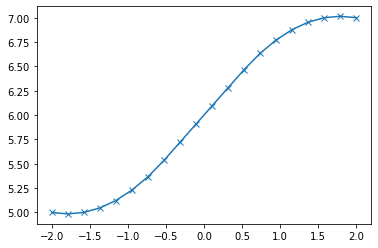

In [5]:
pp.control.plot_characteristic(net.characteristic.object.at[0], -2, 2)

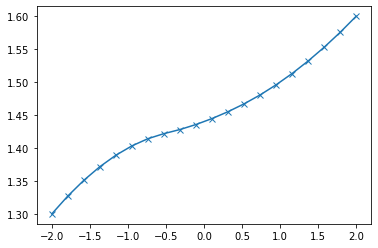

In [6]:
pp.control.plot_characteristic(net.characteristic.object.at[1], -2, 2)

In [7]:
pp.runpp(net)

Let us verify that the adjusted values were considered in the calculation:

In [8]:
net.res_bus.loc[[2,3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-3.390736,0.2,0.05
3,0.935414,-2.890645,0.2,0.05


Now let us compare the computation time

In [9]:
net2 = create_net()

In [10]:
%timeit pp.runpp(net2)

8.77 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit pp.runpp(net)

10.6 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The calculation with tap dependent impedance is about 4 percent slower

Now, let us compare the performance of the controller for reference

In [12]:
net3 = create_net()
pp.control.SplineCharacteristic(net3, [-2, -1, 0, 1, 2], [5, 5.2, 6, 6.8, 7])
pp.control.SplineCharacteristic(net3, [-2, -1, 0, 1, 2], [1.3, 1.4, 1.44, 1.5, 1.6])
pp.control.TapDependentImpedance(net3, [0], 0, output_variable="vk_percent")
pp.control.TapDependentImpedance(net3, [0], 1, output_variable="vkr_percent");

In [13]:
%timeit pp.runpp(net3, run_control=True)

29.2 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The computational time is 3,3 times higher!

The results are identical:

In [14]:
net3.res_bus.loc[[2,3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-3.390736,0.2,0.05
3,0.935414,-2.890645,0.2,0.05


In [15]:
assert np.allclose(net.res_bus.vm_pu, net3.res_bus.vm_pu, atol=1e-6, rtol=0)
assert np.allclose(net.res_bus.va_degree, net3.res_bus.va_degree, atol=1e-6, rtol=0)

# 3-Winding Transformers

In [16]:
net4 = create_net()
net5 = create_net()
for i in range(2):
    add_trafo_connection(net4, net4.trafo.at[0, 'hv_bus'], "3W")
    add_trafo_connection(net5, net5.trafo.at[0, 'hv_bus'], "3W")

In [17]:
pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vk_hv_percent', [[-2, -1, 0, 1, 2]], [[0.85, 0.9, 1, 1.1, 1.15]])
pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vkr_hv_percent', [[-2, -1, 0, 1, 2]], [[0.27, 0.28, 0.3, 0.32, 0.33]])
pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vk_mv_percent', [[-2, -1, 0, 1, 2]], [[0.85, 0.9, 1, 1.1, 1.15]])
pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vkr_mv_percent', [[-2, -1, 0, 1, 2]], [[0.27, 0.28, 0.3, 0.32, 0.33]])
pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vk_lv_percent', [[-2, -1, 0, 1, 2]], [[0.85, 0.9, 1, 1.1, 1.15]])
pp.control.create_trafo_characteristics(net4, 'trafo3w', [0], 'vkr_lv_percent', [[-2, -1, 0, 1, 2]], [[0.27, 0.28, 0.3, 0.32, 0.33]])

net4.characteristic

,object
0,SplineCharacteristic
1,SplineCharacteristic
2,SplineCharacteristic
3,SplineCharacteristic
4,SplineCharacteristic
5,SplineCharacteristic


In [18]:
pp.control.SplineCharacteristic(net5, [-2, -1, 0, 1, 2], [0.85, 0.9, 1, 1.1, 1.15])
pp.control.SplineCharacteristic(net5, [-2, -1, 0, 1, 2], [0.27, 0.28, 0.3, 0.32, 0.33])

SplineCharacteristic

In [19]:
pp.control.TapDependentImpedance(net5, [0], 0, output_variable="vk_hv_percent", trafotable="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 1, output_variable="vkr_hv_percent", trafotable="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 0, output_variable="vk_mv_percent", trafotable="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 1, output_variable="vkr_mv_percent", trafotable="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 0, output_variable="vk_lv_percent", trafotable="trafo3w")
pp.control.TapDependentImpedance(net5, [0], 1, output_variable="vkr_lv_percent", trafotable="trafo3w");

In [20]:
%timeit pp.runpp(net4)

15 ms ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit pp.runpp(net5, run_control=True)

52.1 ms ± 678 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
assert np.allclose(net4.res_bus.vm_pu, net5.res_bus.vm_pu, atol=1e-6, rtol=0)
assert np.allclose(net4.res_bus.va_degree, net5.res_bus.va_degree, atol=1e-6, rtol=0)
pd.merge(net4.res_bus[["vm_pu", "va_degree"]], net5.res_bus[["vm_pu", "va_degree"]], left_index=True, right_index=True)

,vm_pu_x,va_degree_x,vm_pu_y,va_degree_y
0,1.010000,0.000000,1.010000,0.000000
1,1.007345,-0.200101,1.007345,-0.200101
2,0.933386,-3.003717,0.933386,-3.003717
3,0.933386,-3.003717,0.933386,-3.003717
4,1.129101,-0.545611,1.129101,-0.545611
5,1.004802,-0.428880,1.004802,-0.428880
6,1.129567,-0.497905,1.129567,-0.497905
7,1.005088,-0.397258,1.005088,-0.397258


# Undefined characteristics

If some transformers have characteristics that do not define all of the columns, the behavior is to ignore the missing characteristic. If tap_dependent_impedance is set to True, but all the characteristics are missing, an error is raised.

In [23]:
net6 = create_net()
pp.control.create_trafo_characteristics(net6, 'trafo', [0], 'vk_percent', [[-2, -1, 0, 1, 2]], [[5, 5.2, 6, 6.8, 7]])
pp.control.create_trafo_characteristics(net6, 'trafo', [0], 'vkr_percent', [[-2, -1, 0, 1, 2]], [[1.3, 1.4, 1.44, 1.5, 1.6]])
pp.control.create_trafo_characteristics(net6, 'trafo', [1], 'vk_percent', [[-2, -1, 0, 1, 2]], [[5, 5.2, 6, 6.8, 7]])

In [24]:
net6.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service,tap_dependent_impedance,vk_percent_characteristic,vkr_percent_characteristic
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,False,1,1.0,True,True,0.0,1.0
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,False,1,1.0,True,True,2.0,NaN


In [25]:
# does not raise an error
pp.runpp(net6)

In [26]:
# this would raise an error:

# net6.trafo.at[1, "vk_percent_characteristic"] = None
# pp.runpp(net6)

# Creating transformers with characteristics

The functions to create transformers were updated to include the parameter tap_dependent_impedance and add the references to the characteristics.

In [27]:
net_create = create_net()
add_trafo_connection(net_create, net_create.trafo.at[0, 'hv_bus'], "3W")

In [28]:
net_create.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,0,-2,2,2.5,0.0,2,False,1,1.0,True
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,0,-2,2,2.5,0.0,2,False,1,1.0,True


In [29]:
c = pp.control.SplineCharacteristic(net_create, [-2, -1, 0, 1, 2], [5, 5.2, 6, 6.8, 7])
pp.create_transformer(net_create, hv_bus=net_create.trafo.at[0, 'hv_bus'], 
                      lv_bus=net_create.trafo.at[0, 'lv_bus'], std_type="0.25 MVA 20/0.4 kV", tap_pos=2, 
                      tap_dependent_impedance=True, vk_percent_characteristic=0)

2

In [30]:
net_create.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service,tap_dependent_impedance,vk_percent_characteristic
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2,2.5,0.0,2,False,1,1.0,True,False,NaN
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,2,2.5,0.0,2,False,1,1.0,True,False,NaN
2,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2,2.5,0.0,2,False,1,1.0,True,True,0.0


In [31]:
pp.runpp(net_create)

# File I/O

The file I/O for characteristics is now implemented via adding the characteristic table:

In [32]:
net2 = pp.from_json_string(pp.to_json(net))
net2.characteristic

,object
0,SplineCharacteristic
1,SplineCharacteristic


De-serialization is working:

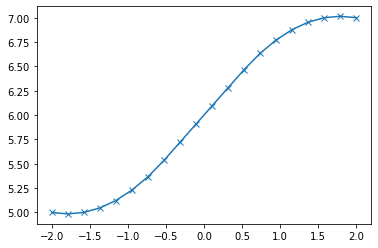

In [33]:
pp.control.plot_characteristic(net2.characteristic.object.at[0], -2, 2)

# Diagnostic

The diagnostic function for transformer tap characteristics checks the following:
 
* Are there characteristics for tap dependent impedance?
* Are any columns missing?
* Are there characteristics that are referenced in the trafo or trafo3w table, but are missing in net.characteristic?

The results are displayed to the user with the help of logging statements.

In [34]:
pp.control.trafo_characteristics_diagnostic(net)

hp.pandapower.control.util.auxiliary - INFO: Checking trafo characteristics
hp.pandapower.control.util.auxiliary - INFO: trafo: found 1 trafos with tap-dependent impedance
hp.pandapower.control.util.auxiliary - INFO: No trafo3w with tap-dependent impedance found.


In [35]:
pp.control.trafo_characteristics_diagnostic(net6)

hp.pandapower.control.util.auxiliary - INFO: Checking trafo characteristics
hp.pandapower.control.util.auxiliary - INFO: trafo: found 2 trafos with tap-dependent impedance
hp.pandapower.control.util.auxiliary - INFO: trafo: vkr_percent_characteristic is missing for some trafos
hp.pandapower.control.util.auxiliary - INFO: No trafo3w with tap-dependent impedance found.
